In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import logging

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Dense, BatchNormalization, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import regularizers
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.callbacks import ReduceLROnPlateau
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [6]:
data = pd.read_csv('spam.csv',encoding='latin-1')

In [7]:
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


# Data Preprocessing

In [8]:
data[data['v1'] == 'spam']['Unnamed: 3'].value_counts()

,count
Unnamed: 3,
"MK17 92H. 450Ppw 16""",2


In [9]:
df = data[['v1','v2']].copy()

In [10]:
le = LabelEncoder()
df['v1'] = le.fit_transform(df['v1'])

X_train, X_test, y_train, y_test = train_test_split(df['v2'], df['v1'], test_size=0.2, random_state=42)


In [22]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post')

## Simple LSTM model

In [31]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [32]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), batch_size=32)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.8653 - loss: 0.4326 - val_accuracy: 0.8655 - val_loss: 0.3981
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.8652 - loss: 0.3966 - val_accuracy: 0.8655 - val_loss: 0.3951
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.8681 - loss: 0.3916 - val_accuracy: 0.8655 - val_loss: 0.3956
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.8595 - loss: 0.4077 - val_accuracy: 0.8655 - val_loss: 0.3953
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.8683 - loss: 0.3902 - val_accuracy: 0.8655 - val_loss: 0.3951
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.8731 - loss: 0.3816 - val_accuracy: 0.8655 - val_loss: 0.3964
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.8614 - loss: 0.4049 - val_accuracy: 0.8655 - val_loss: 0.3952
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.8604 - loss: 0

In [33]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8760 - loss: 0.3750
Test Accuracy: 0.87


In [34]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post')

In [35]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

In [36]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), batch_size=32)
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.8372 - loss: 0.4335 - val_accuracy: 0.8655 - val_loss: 0.3958
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.8692 - loss: 0.3899 - val_accuracy: 0.8655 - val_loss: 0.3952
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.8606 - loss: 0.4043 - val_accuracy: 0.8655 - val_loss: 0.3954
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.8713 - loss: 0.3860 - val_accuracy: 0.8655 - val_loss: 0.3979
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.8601 - loss: 0.4054 - val_accuracy: 0.8655 - val_loss: 0.3951
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.8684 - loss: 0.3899 - val_accuracy: 0.8655 - val_loss: 0.3950
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.8661 - loss: 0.3948 - val_accuracy: 0.8655 - val_loss: 0.3958
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 0.8604 - loss: 0

## More complex LSTM

In [37]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post')

In [38]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

In [39]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), batch_size=32)
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 47s 294ms/step - accuracy: 0.8591 - loss: 0.4214 - val_accuracy: 0.8655 - val_loss: 0.3950
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - accuracy: 0.8609 - loss: 0.4053 - val_accuracy: 0.8655 - val_loss: 0.3960
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 294ms/step - accuracy: 0.8714 - loss: 0.3844 - val_accuracy: 0.8655 - val_loss: 0.4044
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 293ms/step - accuracy: 0.8706 - loss: 0.3891 - val_accuracy: 0.8655 - val_loss: 0.3950
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 287ms/step - accuracy: 0.8645 - loss: 0.3976 - val_accuracy: 0.8655 - val_loss: 0.3967
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 289ms/step - accuracy: 0.8655 - loss: 0.3973 - val_accuracy: 0.8655 - val_loss: 0.3965
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 294ms/step - accuracy: 0.8708 - loss: 0.3879 - val_accuracy: 0.8655 - val_loss: 0.3950
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 294ms/step - accuracy: 0.8670 - loss: 0

## Bidirectionnal LSTM

In [40]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post')

In [41]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

In [42]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), batch_size=32)
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 40s 226ms/step - accuracy: 0.8821 - loss: 0.2813 - val_accuracy: 0.9857 - val_loss: 0.0702
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - accuracy: 0.9917 - loss: 0.0355 - val_accuracy: 0.9865 - val_loss: 0.0671
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 219ms/step - accuracy: 0.9969 - loss: 0.0141 - val_accuracy: 0.9830 - val_loss: 0.0745
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 222ms/step - accuracy: 0.9990 - loss: 0.0056 - val_accuracy: 0.9812 - val_loss: 0.0779
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9821 - val_loss: 0.0888
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - accuracy: 0.9991 - loss: 0.0029 - val_accuracy: 0.9839 - val_loss: 0.0902
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - accuracy: 1.0000 - loss: 5.4558e-04 - val_accuracy: 0.9848 - val_loss: 0.1012
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 224ms/step - accuracy: 1.0000 - los

In [43]:
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step
Accuracy: 0.9821
Precision: 0.9514
Recall: 0.9133
F1-Score: 0.9320


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


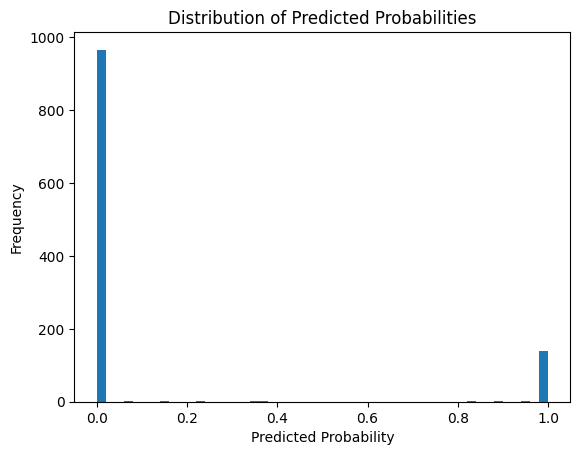

In [44]:
import matplotlib.pyplot as plt

y_pred_prob = model.predict(X_test_pad)
plt.hist(y_pred_prob, bins=50)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

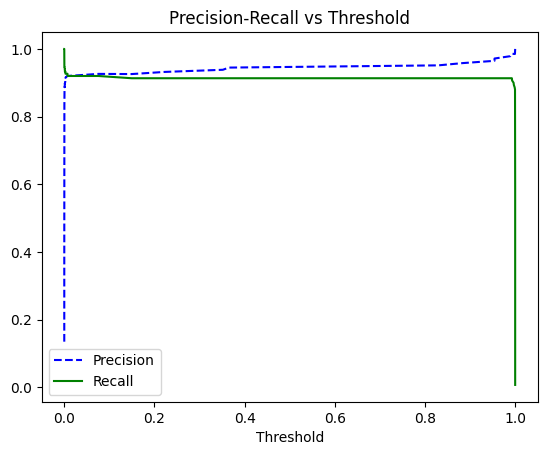

In [45]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision-Recall vs Threshold")
plt.show()

In [46]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post')

In [47]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Bidirectional(LSTM(128, return_sequences=True,kernel_regularizer=regularizers.l2(0.1))),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=True,kernel_regularizer=regularizers.l2(0.1))),
    Dropout(0.2),
    Bidirectional(LSTM(32,kernel_regularizer=regularizers.l2(0.1))),
    Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.1))
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [48]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
history = model.fit(X_train_pad, y_train, epochs=7, validation_data=(X_test_pad, y_test), batch_size=32, callbacks=[reduce_lr])
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/7
140/140 ━━━━━━━━━━━━━━━━━━━━ 117s 756ms/step - accuracy: 0.8941 - loss: 57.5267 - val_accuracy: 0.9094 - val_loss: 1.4697 - learning_rate: 0.0010
Epoch 2/7
140/140 ━━━━━━━━━━━━━━━━━━━━ 142s 750ms/step - accuracy: 0.9303 - loss: 0.8236 - val_accuracy: 0.9103 - val_loss: 0.2869 - learning_rate: 0.0010
Epoch 3/7
140/140 ━━━━━━━━━━━━━━━━━━━━ 103s 740ms/step - accuracy: 0.9707 - loss: 0.2234 - val_accuracy: 0.9677 - val_loss: 0.1810 - learning_rate: 0.0010
Epoch 4/7
140/140 ━━━━━━━━━━━━━━━━━━━━ 147s 778ms/step - accuracy: 0.9864 - loss: 0.1749 - val_accuracy: 0.9399 - val_loss: 0.2619 - learning_rate: 0.0010
Epoch 5/7
140/140 ━━━━━━━━━━━━━━━━━━━━ 137s 744ms/step - accuracy: 0.9662 - loss: 0.2179 - val_accuracy: 0.7874 - val_loss: 0.3858 - learning_rate: 0.0010
Epoch 6/7
140/140 ━━━━━━━━━━━━━━━━━━━━ 146s 774ms/step - accuracy: 0.8428 - loss: 0.3243 - val_accuracy: 0.8753 - val_loss: 0.2797 - learning_rate: 5.0000e-04
Epoch 7/7
140/140 ━━━━━━━━━━━━━━━━━━━━ 138s 747ms/step - accuracy

In [49]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
history = model.fit(X_train_pad, y_train, epochs=6, validation_data=(X_test_pad, y_test), batch_size=32, callbacks=[reduce_lr])
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/6
140/140 ━━━━━━━━━━━━━━━━━━━━ 117s 751ms/step - accuracy: 0.9256 - loss: 0.2860 - val_accuracy: 0.8655 - val_loss: 0.4423 - learning_rate: 0.0010
Epoch 2/6
140/140 ━━━━━━━━━━━━━━━━━━━━ 141s 747ms/step - accuracy: 0.8746 - loss: 0.4158 - val_accuracy: 0.8655 - val_loss: 0.4162 - learning_rate: 0.0010
Epoch 3/6
140/140 ━━━━━━━━━━━━━━━━━━━━ 109s 778ms/step - accuracy: 0.8628 - loss: 0.4197 - val_accuracy: 0.8655 - val_loss: 0.4090 - learning_rate: 0.0010
Epoch 4/6
140/140 ━━━━━━━━━━━━━━━━━━━━ 137s 746ms/step - accuracy: 0.8601 - loss: 0.4178 - val_accuracy: 0.8655 - val_loss: 0.4100 - learning_rate: 0.0010
Epoch 5/6
140/140 ━━━━━━━━━━━━━━━━━━━━ 104s 743ms/step - accuracy: 0.8704 - loss: 0.3979 - val_accuracy: 0.8655 - val_loss: 0.4059 - learning_rate: 0.0010
Epoch 6/6
140/140 ━━━━━━━━━━━━━━━━━━━━ 109s 779ms/step - accuracy: 0.8690 - loss: 0.3983 - val_accuracy: 0.8655 - val_loss: 0.4047 - learning_rate: 0.0010
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.8760 - loss: 0.

## Convolution Neural Network

In [50]:
cnn_model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [51]:
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train_pad, y_train, epochs=8, validation_data=(X_test_pad, y_test), batch_size=32)
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_pad, y_test)
print(f"CNN Test Accuracy: {cnn_accuracy:.2f}")

Epoch 1/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8680 - loss: 0.4422 - val_accuracy: 0.9713 - val_loss: 0.1328
Epoch 2/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9793 - loss: 0.0786 - val_accuracy: 0.9865 - val_loss: 0.0506
Epoch 3/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9956 - loss: 0.0154 - val_accuracy: 0.9865 - val_loss: 0.0478
Epoch 4/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9985 - loss: 0.0061 - val_accuracy: 0.9865 - val_loss: 0.0480
Epoch 5/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9994 - loss: 0.0026 - val_accuracy: 0.9874 - val_loss: 0.0519
Epoch 6/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9857 - val_loss: 0.0539
Epoch 7/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9998 - loss: 9.7169e-04 - val_accuracy: 0.9865 - val_loss: 0.0557
Epoch 8/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9997 - loss: 9.2037e-04 - val_accu

In [52]:
y_pred = (cnn_model.predict(X_test_pad) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Accuracy: 0.9883
Precision: 0.9724
Recall: 0.9400
F1-Score: 0.9559


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


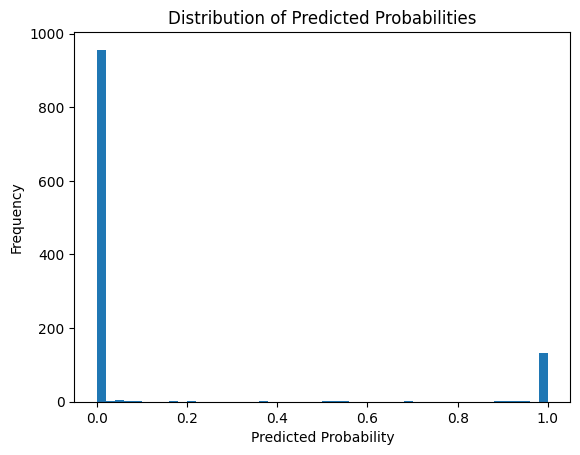

In [53]:
y_pred_prob = cnn_model.predict(X_test_pad)
plt.hist(y_pred_prob, bins=50)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

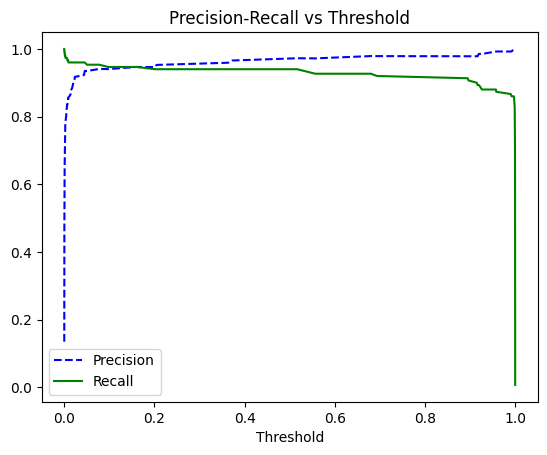

In [54]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision-Recall vs Threshold")
plt.show()

## CNN + L1

In [55]:

def build_and_train_model(l1_ratio):
    print(f"\nTraining CNN model with L1 regularization ratio: {l1_ratio}")
    model = Sequential([
        Embedding(input_dim=5000, output_dim=64, input_length=100),
        Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l1(l1_ratio)),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(10, activation='relu', kernel_regularizer=regularizers.l1(l1_ratio)),
        Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(l1_ratio))
    ])


    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_pad, y_train, epochs=13, validation_data=(X_test_pad, y_test), batch_size=32)

    loss, test_accuracy = model.evaluate(X_test_pad, y_test)
    print(f"Test Accuracy for L1 ratio {l1_ratio}: {test_accuracy:.2f}")
    y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return test_accuracy, loss, accuracy, precision, recall, f1


results = {}
for l1_ratio in [0.00005, 0.0001, 0.0005]:
    test_accuracy, loss, accuracy, precision, recall, f1 = build_and_train_model(l1_ratio)
    results[l1_ratio] = {'test_accuracy': accuracy, 'loss': loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}


for l1_ratio, metrics in results.items():
    print(f"\nL1 Ratio: {l1_ratio} - Test Accuracy: {metrics['test_accuracy']:.4f}, Test Loss: {metrics['loss']:.4f}")



Training CNN model with L1 regularization ratio: 5e-05
Epoch 1/13


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8618 - loss: 0.5023 - val_accuracy: 0.9830 - val_loss: 0.1454
Epoch 2/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9891 - loss: 0.1151 - val_accuracy: 0.9848 - val_loss: 0.1065
Epoch 3/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9947 - loss: 0.0754 - val_accuracy: 0.9848 - val_loss: 0.0964
Epoch 4/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9984 - loss: 0.0551 - val_accuracy: 0.9848 - val_loss: 0.0891
Epoch 5/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9999 - loss: 0.0447 - val_accuracy: 0.9865 - val_loss: 0.0793
Epoch 6/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9998 - loss: 0.0378 - val_accuracy: 0.9857 - val_loss: 0.0808
Epoch 7/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9998 - loss: 0.0343 - val_accuracy: 0.9874 - val_loss: 0.0732
Epoch 8/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9999 - loss: 0.0306 - val_accuracy: 0.984

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8396 - loss: 0.6020 - val_accuracy: 0.9426 - val_loss: 0.2409
Epoch 2/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9695 - loss: 0.1787 - val_accuracy: 0.9865 - val_loss: 0.1295
Epoch 3/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9919 - loss: 0.1034 - val_accuracy: 0.9874 - val_loss: 0.1087
Epoch 4/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9917 - loss: 0.0875 - val_accuracy: 0.9883 - val_loss: 0.0992
Epoch 5/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9966 - loss: 0.0642 - val_accuracy: 0.9839 - val_loss: 0.0979
Epoch 6/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9986 - loss: 0.0558 - val_accuracy: 0.9848 - val_loss: 0.0897
Epoch 7/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9985 - loss: 0.0488 - val_accuracy: 0.9839 - val_loss: 0.0885
Epoch 8/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9989 - loss: 0.0459 - val_accuracy: 0.984

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8583 - loss: 0.9787 - val_accuracy: 0.8655 - val_loss: 0.4731
Epoch 2/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8627 - loss: 0.4702 - val_accuracy: 0.8655 - val_loss: 0.4054
Epoch 3/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8917 - loss: 0.3424 - val_accuracy: 0.9534 - val_loss: 0.2120
Epoch 4/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9440 - loss: 0.2232 - val_accuracy: 0.9812 - val_loss: 0.1545
Epoch 5/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9721 - loss: 0.1650 - val_accuracy: 0.9830 - val_loss: 0.1329
Epoch 6/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9794 - loss: 0.1360 - val_accuracy: 0.9848 - val_loss: 0.1217
Epoch 7/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9837 - loss: 0.1278 - val_accuracy: 0.9848 - val_loss: 0.1195
Epoch 8/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9902 - loss: 0.1099 - val_accuracy: 0.984

In [56]:
l1_ratio = 0.0001
cnn_l1_model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l1(l1_ratio)),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(10, activation='relu', kernel_regularizer=regularizers.l1(l1_ratio)),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(l1_ratio))
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [57]:
cnn_l1_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = cnn_l1_model.fit(X_train_pad, y_train, epochs=13, validation_data=(X_test_pad, y_test), batch_size=32)

loss, test_accuracy = cnn_l1_model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy for L1 ratio {l1_ratio}: {test_accuracy:.2f}")
y_pred = (cnn_l1_model.predict(X_test_pad) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Epoch 1/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8306 - loss: 0.5989 - val_accuracy: 0.9749 - val_loss: 0.2500
Epoch 2/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9782 - loss: 0.1875 - val_accuracy: 0.9865 - val_loss: 0.1332
Epoch 3/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9917 - loss: 0.1053 - val_accuracy: 0.9874 - val_loss: 0.1109
Epoch 4/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9941 - loss: 0.0851 - val_accuracy: 0.9883 - val_loss: 0.1011
Epoch 5/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9984 - loss: 0.0640 - val_accuracy: 0.9865 - val_loss: 0.0934
Epoch 6/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9983 - loss: 0.0547 - val_accuracy: 0.9874 - val_loss: 0.0889
Epoch 7/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9984 - loss: 0.0497 - val_accuracy: 0.9848 - val_loss: 0.0866
Epoch 8/13
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9985 - loss: 0.0458 - val_accu

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


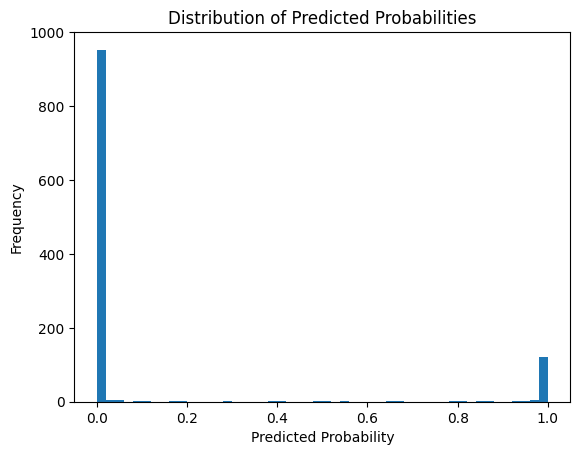

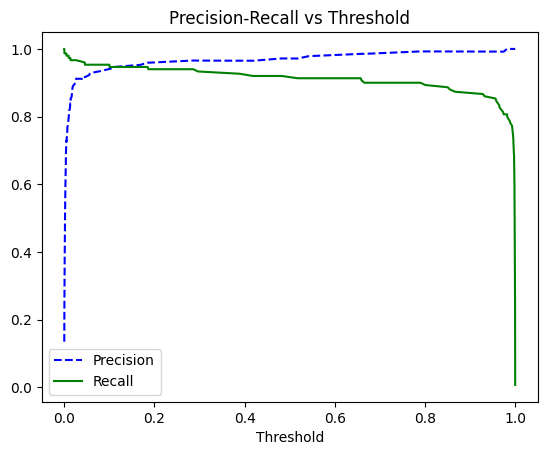

In [58]:
y_pred_prob = cnn_l1_model.predict(X_test_pad)
plt.hist(y_pred_prob, bins=50)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision-Recall vs Threshold")
plt.show()

In [59]:
print(f"Test Accuracy for L1 ratio {l1_ratio}: {test_accuracy:.2f}")
y_pred = (cnn_l1_model.predict(X_test_pad) > 0.6).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Test Accuracy for L1 ratio 0.0001: 0.98
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.9865
Precision: 0.9856
Recall: 0.9133
F1-Score: 0.9481


CNN + l1 (=0.0001) shows ecxellent results. A thershold of 0.6 seems to be optimal to get the best precision (classifie 'ham' as 'spam' the as little as possible (only 2.1% of 'spam' are actually 'ham') while keeping a really decent recall (92.7% of 'spam' are rightfully categorize)

## More Complex CNN

In [20]:
l1_ratio = 0.0001
ccnn_l1_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),

    Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l1(l1_ratio)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l1(l1_ratio)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l1(l1_ratio)),
    BatchNormalization(),
    GlobalMaxPooling1D(),

    Dense(64, activation='relu', kernel_regularizer=regularizers.l1(l1_ratio)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l1(l1_ratio)),

    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(l1_ratio))
])

In [28]:
ccnn_l1_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = ccnn_l1_model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), batch_size=32)



Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 35s 176ms/step - accuracy: 0.9941 - loss: 0.3626 - val_accuracy: 0.9803 - val_loss: 0.4542
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.9951 - loss: 0.2917 - val_accuracy: 0.9516 - val_loss: 0.4493
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9942 - loss: 0.2519 - val_accuracy: 0.9731 - val_loss: 0.3633
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9971 - loss: 0.2306 - val_accuracy: 0.9632 - val_loss: 0.5316
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.9907 - loss: 0.2931 - val_accuracy: 0.9704 - val_loss: 0.3365
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.9979 - loss: 0.2150 - val_accuracy: 0.9767 - val_loss: 0.3601
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.9972 - loss: 0.1931 - val_accuracy: 0.9650 - val_loss: 0.6399
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9974 - loss: 0

In [29]:
loss, test_accuracy = ccnn_l1_model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy for L1 ratio {l1_ratio}: {test_accuracy:.2f}")


y_pred = (ccnn_l1_model.predict(X_test_pad) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9860 - loss: 0.2656
Test Accuracy for L1 ratio 0.0001: 0.98
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Accuracy: 0.9812
Precision: 0.9778
Recall: 0.8800
F1-Score: 0.9263


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


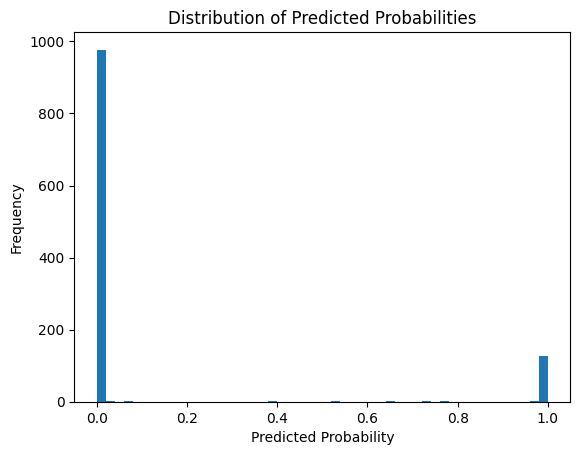

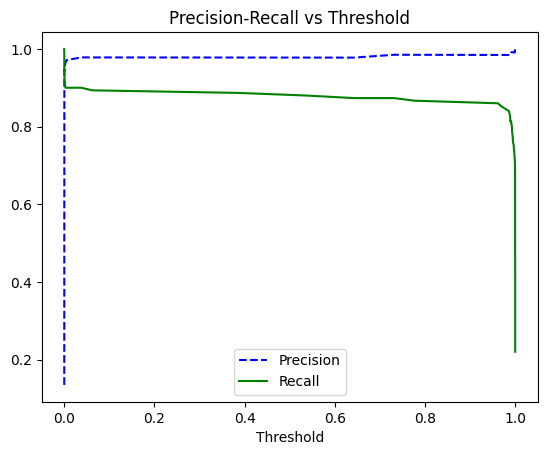

In [30]:
y_pred_prob = ccnn_l1_model.predict(X_test_pad)
plt.hist(y_pred_prob, bins=50)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision-Recall vs Threshold")
plt.show()

## Transformers

In [ ]:

os.environ["WANDB_DISABLED"] = "true"


logging.basicConfig(level=logging.INFO)


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", clean_up_tokenization_spaces=False)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


def tokenize_data(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=100, return_tensors="pt")

X_train_text, X_val_text, y_train_labels, y_val_labels = train_test_split(df['v2'], df['v1'], test_size=0.2, random_state=42)
train_encodings = tokenize_data(X_train_text.tolist())
val_encodings = tokenize_data(X_val_text.tolist())

train_labels = torch.tensor(y_train_labels.values)
val_labels = torch.tensor(y_val_labels.values)


class SpamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SpamDataset(train_encodings, train_labels)
val_dataset = SpamDataset(val_encodings, val_labels)


training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,  
    report_to="none"
)


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-64-890e77041a20>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.022700,0.033090,0.993722,0.976271,0.993103,0.960000
2,0.020200,0.029044,0.992825,0.973510,0.967105,0.980000
3,0.001300,0.028112,0.993722,0.976589,0.979866,0.973333


<ipython-input-64-890e77041a20>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-64-890e77041a20>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-64-890e77041a20>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-64-890e77041a20>:36: UserWarning: To copy construct fro

TrainOutput(global_step=837, training_loss=0.04262109430842858, metrics={'train_runtime': 7165.3953, 'train_samples_per_second': 1.866, 'train_steps_per_second': 0.117, 'total_flos': 345941716294800.0, 'train_loss': 0.04262109430842858, 'epoch': 3.0})

In [ ]:
os.environ["WANDB_DISABLED"] = "true"


logging.basicConfig(level=logging.INFO)


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", clean_up_tokenization_spaces=False)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


def tokenize_data(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=100, return_tensors="pt")

X_train_text, X_val_text, y_train_labels, y_val_labels = train_test_split(df['v2'], df['v1'], test_size=0.2, random_state=42)
train_encodings = tokenize_data(X_train_text.tolist())
val_encodings = tokenize_data(X_val_text.tolist())

train_labels = torch.tensor(y_train_labels.values)
val_labels = torch.tensor(y_val_labels.values)


class SpamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SpamDataset(train_encodings, train_labels)
val_dataset = SpamDataset(val_encodings, val_labels)


training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=13,
    weight_decay=0.01,
    logging_steps=10,  
    report_to="none"
)


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-66-91e3e6de6a86>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.009000,0.026660,0.993722,0.976271,0.993103,0.960000
2,0.030100,0.028274,0.993722,0.976744,0.973510,0.980000
3,0.000500,0.028856,0.994619,0.979730,0.993151,0.966667
4,0.000200,0.020283,0.996413,0.986577,0.993243,0.980000
5,0.000300,0.024712,0.995516,0.983389,0.980132,0.986667
6,0.000100,0.026241,0.996413,0.986577,0.993243,0.980000
7,0.000100,0.028649,0.995516,0.983165,0.993197,0.973333
8,0.000100,0.030331,0.995516,0.983165,0.993197,0.973333
9,0.000000,0.031372,0.995516,0.983165,0.993197,0.973333
10,0.000000,0.031914,0.995516,0.983165,0.993197,0.973333


<ipython-input-66-91e3e6de6a86>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-66-91e3e6de6a86>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-66-91e3e6de6a86>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-66-91e3e6de6a86>:28: UserWarning: To copy construct fro

TrainOutput(global_step=3627, training_loss=0.009167523638494615, metrics={'train_runtime': 31292.6068, 'train_samples_per_second': 1.852, 'train_steps_per_second': 0.116, 'total_flos': 1499080770610800.0, 'train_loss': 0.009167523638494615, 'epoch': 13.0})